<a href="https://colab.research.google.com/github/shuvrodas13/DataSet/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geocoders

ERROR: Could not find a version that satisfies the requirement geocoders (from versions: none)
ERROR: No matching distribution found for geocoders


In [107]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from tqdm.notebook import tqdm
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import plot_acf and plot_pacf

from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

from scipy.stats import f_oneway, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


## Load Data

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
data = pd.read_csv('/content/drive/MyDrive/Plane Accident/Data/data.csv')


## Clean Data

In [110]:
data.head()

,date,time,location,operator,flight_no,route,ac_type,registration,cn_ln,all_aboard,passengers_aboard,crew_aboard,all_fatalities,passenger_fatalities,crew_fatalities,ground,summary,year
0,9/17/1908,1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908
1,9/7/1909,?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909
2,7/12/1912,630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912
3,8/6/1913,?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913
4,9/9/1913,1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,1913


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  5052 non-null   object 
 1   time                  5052 non-null   object 
 2   location              5052 non-null   object 
 3   operator              5052 non-null   object 
 4   flight_no             5052 non-null   object 
 5   route                 5052 non-null   object 
 6   ac_type               5052 non-null   object 
 7   registration          5052 non-null   object 
 8   cn_ln                 5052 non-null   object 
 9   all_aboard            5035 non-null   float64
 10  passengers_aboard     4831 non-null   float64
 11  crew_aboard           4833 non-null   float64
 12  all_fatalities        5044 non-null   float64
 13  passenger_fatalities  4818 non-null   float64
 14  crew_fatalities       4818 non-null   float64
 15  ground               

In [112]:
# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

In [113]:
# Convert Relevant Columns to Numeric
cols_to_convert = ['passenger_fatalities', 'crew_fatalities', 'ground', 'all_fatalities', 'passengers_aboard', 'crew_aboard']
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill Missing Values with 0
data[cols_to_convert] = data[cols_to_convert].fillna(0)

In [114]:
# Handle missing values
data.dropna(subset=['date'], inplace=True)  # Remove rows with critical missing data
data['route'].fillna('Unknown', inplace=True)  # Fill missing routes with 'Unknown'

<ipython-input-114-9e19c23dc71e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['route'].fillna('Unknown', inplace=True)  # Fill missing routes with 'Unknown'


In [115]:
# Basic statistics
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
                                date   all_aboard  passengers_aboard  \
count                           5052  5035.000000        5052.000000   
mean   1971-08-11 19:05:16.389548616    31.200199          25.792557   
min              1908-09-17 00:00:00     0.000000           0.000000   
25%              1951-07-12 00:00:00     7.000000           2.000000   
50%              1970-10-03 00:00:00    16.000000          11.000000   
75%              1992-07-13 06:00:00    35.000000          29.000000   
max              2024-12-29 00:00:00   644.000000         614.000000   
std                              NaN    45.774816          43.697491   

       crew_aboard  all_fatalities  passenger_fatalities  crew_fatalities  \
count  5052.000000     5052.000000           5052.000000      5052.000000   
mean      4.331750       22.217538             18.032264         3.411124   
min       0.000000        0.000000              0.000000         0.000000   
25%       2.000000    

In [116]:
# Replace '?' and non-numeric values with NaN
data['time'] = data['time'].astype(str).str.strip()  # Remove spaces
data['time'] = data['time'].apply(lambda x: x if x.isdigit() else np.nan)

# Standardize time format
def fix_time_format(time_str):
    if pd.isna(time_str):  # If NaN, return as is
        return np.nan
    time_str = str(time_str)

    # If the length is 3, assume leading zero (e.g., '344' -> '0344')
    if len(time_str) == 3:
        time_str = '0' + time_str

    # If it's now a valid 4-digit time, convert to HH:MM
    if len(time_str) == 4:
        return f"{time_str[:2]}:{time_str[2:]}"

    return np.nan  # Anything else is invalid

# Apply the function to clean time values
data['time'] = data['time'].apply(fix_time_format)

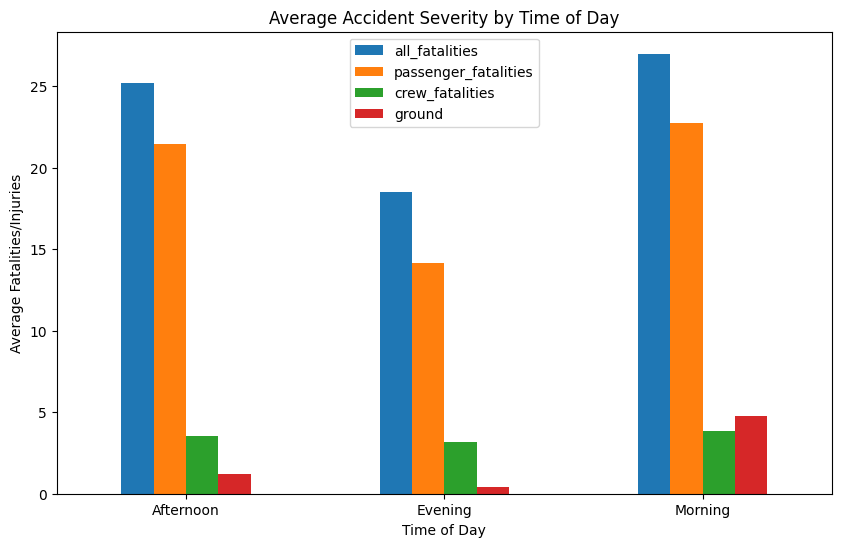

             all_fatalities  passenger_fatalities  crew_fatalities    ground
time_of_day                                                                 
Afternoon         25.171113             21.432383         3.530819  1.198712
Evening           18.515499             14.179487         3.147340  0.391887
Morning           26.997781             22.744822         3.824704  4.750000


In [117]:
# Replace '?' with NaN in the 'time' column and fix invalid entries
data['time'] = data['time'].replace('?', np.nan)
data['time'] = pd.to_datetime(data['time'], format='%H:%M', errors='coerce')

# Extract hours from time for grouping
data['hour'] = data['time'].dt.hour

# Define time categories
def time_category(hour):
    if hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the time category function
data['time_of_day'] = data['hour'].apply(time_category)

# Check for columns related to accidents (e.g., all_fatalities, passenger_fatalities)
accident_columns = ['all_fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground']

# Calculate average accident severity for each time category
accident_stats = data.groupby('time_of_day')[accident_columns].mean()

# Plot the results
accident_stats.plot(kind='bar', figsize=(10,6))
plt.title('Average Accident Severity by Time of Day')
plt.ylabel('Average Fatalities/Injuries')
plt.xlabel('Time of Day')
plt.xticks(rotation=0)
plt.show()

# Display the accident stats
print(accident_stats)

# Feature Selection


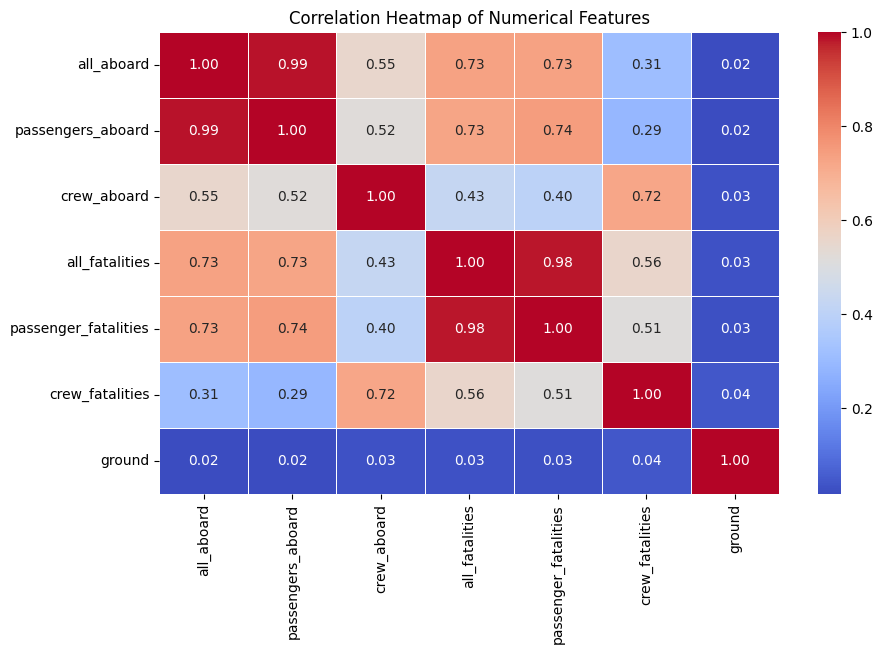

                      all_aboard  passengers_aboard  crew_aboard  \
all_aboard              1.000000           0.985986     0.552927   
passengers_aboard       0.985986           1.000000     0.519524   
crew_aboard             0.552927           0.519524     1.000000   
all_fatalities          0.733021           0.726082     0.425704   
passenger_fatalities    0.732100           0.743403     0.401238   
crew_fatalities         0.310583           0.287355     0.723450   
ground                  0.019685           0.018542     0.031524   

                      all_fatalities  passenger_fatalities  crew_fatalities  \
all_aboard                  0.733021              0.732100         0.310583   
passengers_aboard           0.726082              0.743403         0.287355   
crew_aboard                 0.425704              0.401238         0.723450   
all_fatalities              1.000000              0.984159         0.557762   
passenger_fatalities        0.984159              1.000000  

In [118]:
# Convert relevant columns to numeric, forcing errors to NaN for non-convertible values
numeric_cols = ['all_aboard', 'passengers_aboard', 'crew_aboard',
                'all_fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
correlation_matrix = data[numeric_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Print the correlation matrix
print(correlation_matrix)

1. Highly Correlated Features (Above 0.7)
all_aboard & passengers_aboard (0.985) → Almost perfectly correlated, meaning most people aboard are passengers.
all_fatalities & passenger_fatalities (0.984) → Most fatalities are passengers.
all_aboard & all_fatalities (0.733) → Higher number of people aboard is linked to more fatalities.
passengers_aboard & passenger_fatalities (0.743) → More passengers aboard leads to more passenger fatalities.
crew_aboard & crew_fatalities (0.723) → More crew members aboard results in more crew fatalities.
2. Moderate Correlation (0.4 - 0.7)
crew_aboard & all_fatalities (0.426) → Crew size has some impact on total fatalities.
crew_aboard & passenger_fatalities (0.401) → More crew means slightly more passenger fatalities.
crew_fatalities & all_fatalities (0.558) → Crew fatalities contribute significantly to total fatalities.
3. Weak or No Correlation (Below 0.1)
ground fatalities have little correlation with other features (below 0.05), meaning ground casualties are independent of onboard factors

In [119]:
# Select categorical features
categorical_cols = ['operator', 'location', 'flight_no', 'route', 'ac_type', 'registration', 'cn_ln']

# Encode categorical features as numerical values
data_encoded = data[categorical_cols].apply(LabelEncoder().fit_transform)

# Compute Mutual Information scores against the target variable (`all_fatalities`)
mi_scores = mutual_info_classif(data_encoded, data['all_fatalities'], discrete_features=True)

# Create a DataFrame to display feature importance
mi_results = pd.DataFrame({'Feature': categorical_cols, 'MI_Score': mi_scores})
mi_results = mi_results.sort_values(by='MI_Score', ascending=False)

# Display results
print(mi_results)

        Feature  MI_Score
5  registration  3.767759
1      location  3.672299
6         cn_ln  3.334083
3         route  3.321719
4       ac_type  2.827944
0      operator  2.626018
2     flight_no  1.151289


In [120]:
data  = data.drop(columns=['flight_no'])

In [121]:
data

,date,time,location,operator,route,ac_type,registration,cn_ln,all_aboard,passengers_aboard,crew_aboard,all_fatalities,passenger_fatalities,crew_fatalities,ground,summary,year,hour,time_of_day
0,1908-09-17,1900-01-01 17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,?,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,17.0,Afternoon
1,1909-09-07,NaT,"Juvisy-sur-Orge, France",?,Air show,Wright Byplane,SC1,?,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,1909,NaN,Evening
2,1912-07-12,1900-01-01 06:30:00,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,?,?,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912,6.0,Morning
3,1913-08-06,NaT,"Victoria, British Columbia, Canada",Private,?,Curtiss seaplane,?,?,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913,NaN,Evening
4,1913-09-09,1900-01-01 18:30:00,Over the North Sea,Military - German Navy,?,Zeppelin L-1 (airship),?,?,20.0,0.0,0.0,14.0,0.0,0.0,0.0,The airship flew into a thunderstorm and encou...,1913,18.0,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5047,2024-08-31,1900-01-01 16:15:00,"Vachkazhets volcano Kamchatka, Russia",Vityaz Aero,Vachkazhets Volcano - Nikolaevka Heliport,Mil Mi-8T,RA-25656,99254295,22.0,19.0,3.0,22.0,19.0,3.0,0.0,The helicopter crashed after strucking rising ...,2024,16.0,Afternoon
5048,2024-10-20,1900-01-01 07:22:00,"Pohuwato, Indonesia",SAM Air,Gorontalo - Pohuwato,de Havilland Canada DHC-6 Twin Otter 300,PK-SMH,462,4.0,1.0,3.0,4.0,1.0,3.0,0.0,While attempting to land at Bumi Panua Pohuwat...,2024,7.0,Morning
5049,2024-11-25,1900-01-01 13:22:00,"Vilnius, Lithuania",Swiftair operating for DHL,Leipzig - Vilnius,Boeing 737-476 SF,EC-MFE,24445/2539,2.0,4.0,2.0,1.0,0.0,1.0,0.0,The cargo plane was destroyed after it crashed...,2024,13.0,Afternoon
5050,2024-12-25,1900-01-01 06:24:00,"Aktau, Kazakhstan",Azerbaijan Airlines,Baku - Grozny,Embraer ERJ-190AR,4K-AZ65,19000630,67.0,62.0,5.0,38.0,36.0,2.0,0.0,The plane departed Baku for regular service to...,2024,6.0,Morning


For time series extract year and all fatlities


In [122]:
# Extract the year from the date
data['year'] = data['date'].dt.year

# Group by year and sum all fatalities
yearly_fatalities = data.groupby('year')['all_fatalities'].sum().reset_index()

# Save the new dataset
yearly_fatalities.to_csv("yearly_fatalities.csv", index=False)

# Show preview
print(yearly_fatalities.head())

   year  all_fatalities
0  1908             1.0
1  1909             1.0
2  1912             5.0
3  1913            43.0
4  1915            36.0


In [123]:
yearly_fatalities

,year,all_fatalities
0,1908,1.0
1,1909,1.0
2,1912,5.0
3,1913,43.0
4,1915,36.0
...,...,...
109,2020,355.0
110,2021,185.0
111,2022,189.0
112,2023,102.0


# Examine the historical evolution of aviation accidents and fatalities in relation to technological advancements and safety protocols.

                                         Total Fatalities  Total Accidents
Early Aviation (1900s - 1920s)                     1064.0            215.0
Golden Age of Aviation (1930s - 1940s)            10962.0            942.0
Jet Age (1950s - 1970s)                           48560.0           1923.0
Modern Era (1980s - 2000s)                        34278.0           1250.0
Contemporary Aviation (2010s - Present)            7632.0            278.0


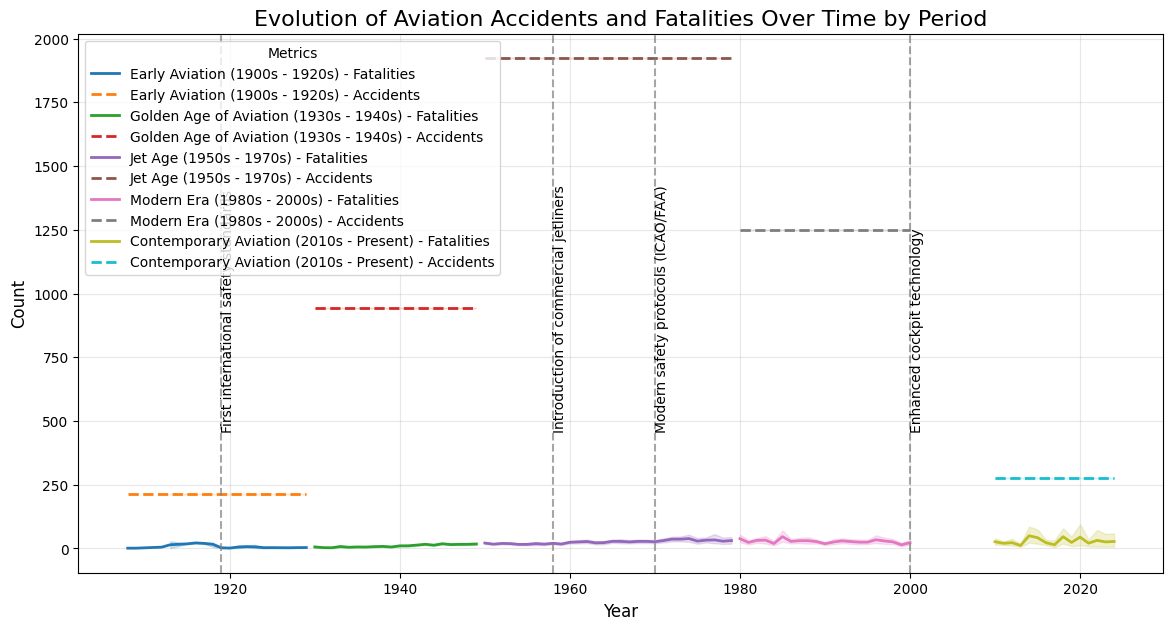

In [124]:


# Data Cleaning
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['all_fatalities'] = pd.to_numeric(data['all_fatalities'], errors='coerce')
data.dropna(subset=['date', 'all_fatalities'], inplace=True)

# Extract Year
data['year'] = data['date'].dt.year

# Define the time periods with their start and end years
periods = {
    'Early Aviation (1900s - 1920s)': (1900, 1929),
    'Golden Age of Aviation (1930s - 1940s)': (1930, 1949),
    'Jet Age (1950s - 1970s)': (1950, 1979),
    'Modern Era (1980s - 2000s)': (1980, 2000),
    'Contemporary Aviation (2010s - Present)': (2010, 2025)
}

# Create a dictionary to hold the results for each period
period_summary = {}

# Loop through each period to filter data and calculate statistics
for period, (start_year, end_year) in periods.items():
    # Filter data by the current period
    period_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]

    # Calculate total fatalities and accidents for the period
    total_fatalities = period_data['all_fatalities'].sum()
    total_accidents = period_data['date'].count()

    # Store the results in the dictionary
    period_summary[period] = {
        'Total Fatalities': total_fatalities,
        'Total Accidents': total_accidents
    }

# Convert the results to a DataFrame for better readability
period_summary_df = pd.DataFrame(period_summary).T
print(period_summary_df)

# Plot the trends for each period
plt.figure(figsize=(14, 7))
for period, (start_year, end_year) in periods.items():
    # Filter data for the current period
    period_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]

    # Plot fatalities and accidents for the period
    sns.lineplot(x=period_data['year'], y=period_data['all_fatalities'], label=f'{period} - Fatalities', linewidth=2)
    sns.lineplot(x=period_data['year'], y=period_data['date'].count(), label=f'{period} - Accidents', linewidth=2, linestyle='--')

plt.title("Evolution of Aviation Accidents and Fatalities Over Time by Period", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Metrics")
plt.grid(alpha=0.3)

# Annotate Key Milestones
milestones = {
    1919: "First international safety standards",
    1958: "Introduction of commercial jetliners",
    1970: "Modern safety protocols (ICAO/FAA)",
    2000: "Enhanced cockpit technology"
}
for year, event in milestones.items():
    if year in data['year'].values:
        plt.axvline(x=year, color='gray', linestyle='--', alpha=0.7)
        plt.text(year, max(data['all_fatalities']) * 0.8, event, rotation=90, color='black')

plt.show()


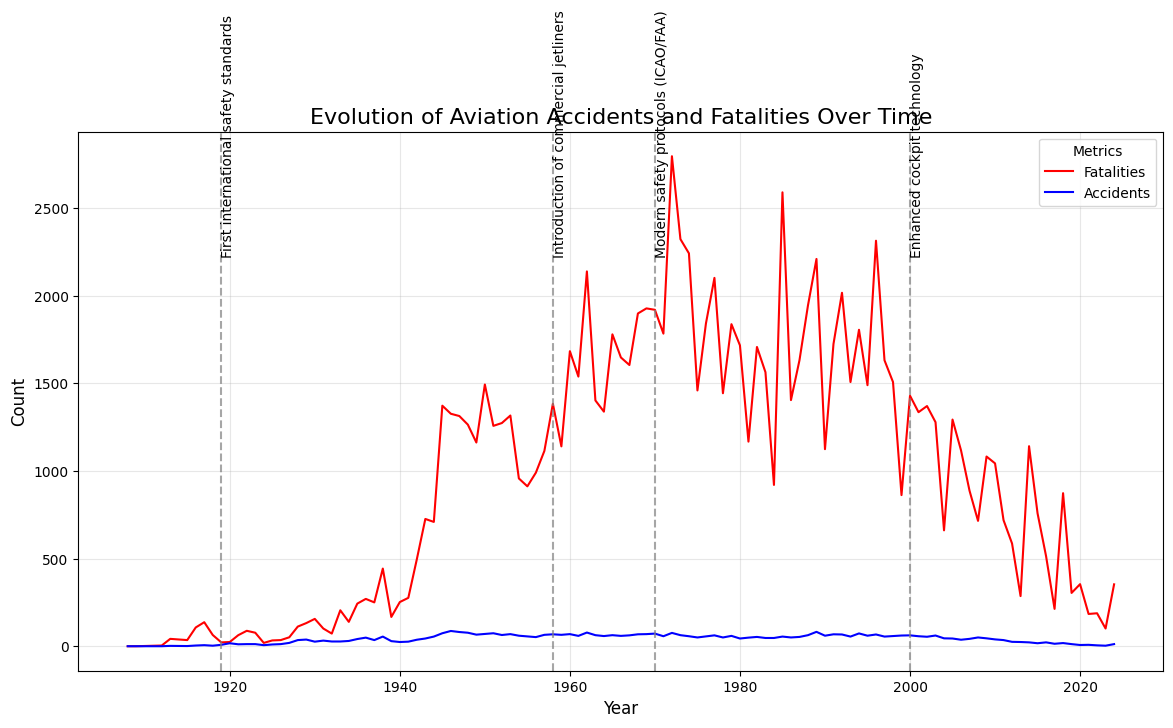

Fatalities Before 1970: 40835.0
Fatalities After 1970: 71408.0
Accidents Before 1970: 2468
Accidents After 1970: 2584


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Data Cleaning
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['all_fatalities'] = pd.to_numeric(data['all_fatalities'], errors='coerce')
data.dropna(subset=['date', 'all_fatalities'], inplace=True)

# Extract Year
data['year'] = data['date'].dt.year

# Group by Year
annual_data = data.groupby('year').agg({
    'all_fatalities': 'sum',
    'date': 'count'  # Counts the number of accidents
}).rename(columns={'date': 'accidents'})

# Plot Trends
plt.figure(figsize=(14, 7))
sns.lineplot(x=annual_data.index, y='all_fatalities', data=annual_data, label='Fatalities', color='red')
sns.lineplot(x=annual_data.index, y='accidents', data=annual_data, label='Accidents', color='blue')
plt.title("Evolution of Aviation Accidents and Fatalities Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Metrics")
plt.grid(alpha=0.3)

# Annotate Key Milestones
milestones = {
    1919: "First international safety standards",
    1958: "Introduction of commercial jetliners",
    1970: "Modern safety protocols (ICAO/FAA)",
    2000: "Enhanced cockpit technology"
}
for year, event in milestones.items():
    if year in annual_data.index:
        plt.axvline(x=year, color='gray', linestyle='--', alpha=0.7)
        plt.text(year, annual_data['all_fatalities'].max() * 0.8, event, rotation=90, color='black')

plt.show()

# Pre- and Post-Innovation Analysis
key_year = 1970
pre_innovation = annual_data[annual_data.index < key_year]
post_innovation = annual_data[annual_data.index >= key_year]

print(f"Fatalities Before {key_year}: {pre_innovation['all_fatalities'].sum()}")
print(f"Fatalities After {key_year}: {post_innovation['all_fatalities'].sum()}")

print(f"Accidents Before {key_year}: {pre_innovation['accidents'].sum()}")
print(f"Accidents After {key_year}: {post_innovation['accidents'].sum()}")


# Analyze the differences in accident rates and severity among military, commercial, and private aviation operators.

In [126]:
# Categorize Operators (Assuming these keywords differentiate categories)
def categorize_operator(operator):
    if "military" in operator.lower():
        return "Military"
    elif "airlines" in operator.lower() or "airways" in operator.lower() or "commercial" in operator.lower():
        return "Commercial"
    else:
        return "Private"

data['operator_category'] = data['operator'].apply(lambda x: categorize_operator(str(x)))

In [127]:
# Group by operator category
operator_stats = data.groupby('operator_category').agg({
    'all_fatalities': ['sum', 'mean'],
    'passenger_fatalities': ['sum', 'mean'],
    'crew_fatalities': ['sum', 'mean'],
    'ground': ['sum', 'mean'],
    'operator_category': 'count'
}).rename(columns={'operator_category': 'accidents'}).reset_index()

In [128]:
# Rename columns for better readability
operator_stats.columns = ['Operator Type', 'Total Fatalities', 'Avg Fatalities',
                          'Total Passenger Fatalities', 'Avg Passenger Fatalities',
                          'Total Crew Fatalities', 'Avg Crew Fatalities',
                          'Total Ground Fatalities', 'Avg Ground Fatalities',
                          'Total Accidents']

In [129]:
# Print summary statistics
print(operator_stats)


  Operator Type  Total Fatalities  Avg Fatalities  Total Passenger Fatalities  \
0    Commercial           34680.0       26.883721                     29944.0   
1      Military           20110.0       26.116883                     13500.0   
2       Private           57453.0       19.202206                     47655.0   

   Avg Passenger Fatalities  Total Crew Fatalities  Avg Crew Fatalities  \
0                 23.212403                 4412.0             3.420155   
1                 17.532468                 3717.0             4.827273   
2                 15.927473                 9104.0             3.042781   

   Total Ground Fatalities  Avg Ground Fatalities  Total Accidents  
0                   3224.0               2.499225             1290  
1                   1227.0               1.593506              770  
2                   4298.0               1.436497             2992  


<ipython-input-130-717d375f956c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=operator_stats, x="Operator Type", y="Total Accidents", palette="coolwarm")


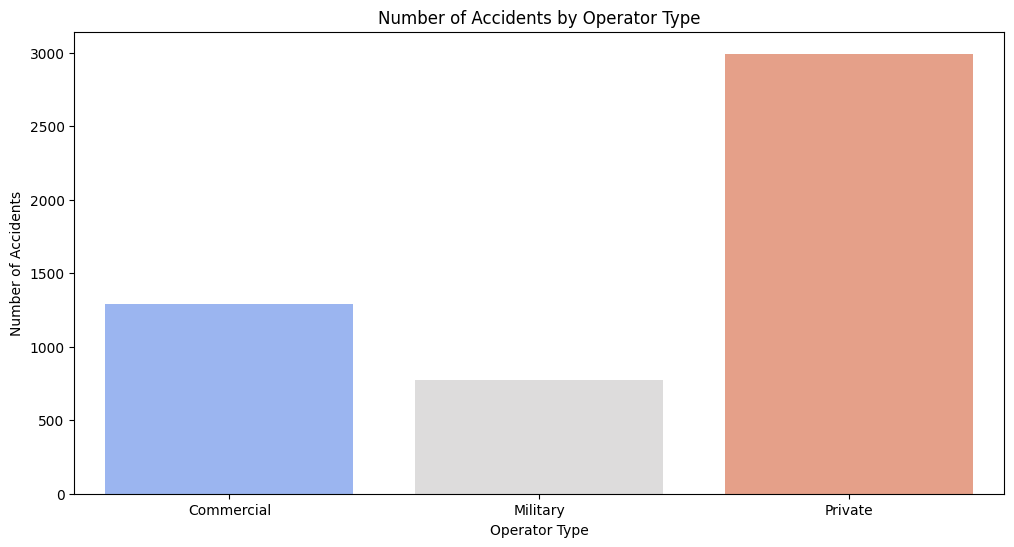

<ipython-input-130-717d375f956c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=operator_stats, x="Operator Type", y="Total Fatalities", palette="Reds")


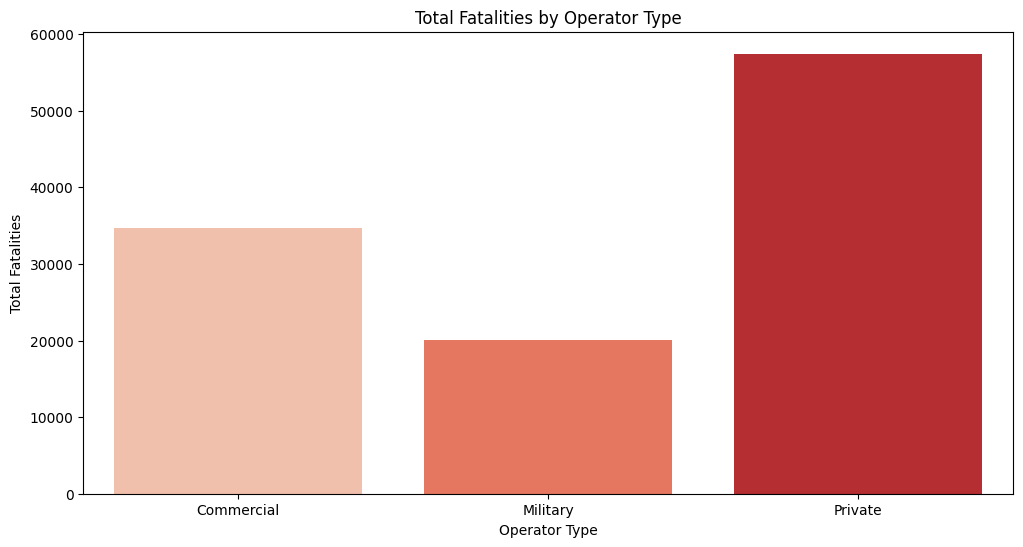

In [130]:
# --- Visualization ---
plt.figure(figsize=(12, 6))
sns.barplot(data=operator_stats, x="Operator Type", y="Total Accidents", palette="coolwarm")
plt.title("Number of Accidents by Operator Type")
plt.ylabel("Number of Accidents")
plt.xlabel("Operator Type")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=operator_stats, x="Operator Type", y="Total Fatalities", palette="Reds")
plt.title("Total Fatalities by Operator Type")
plt.ylabel("Total Fatalities")
plt.xlabel("Operator Type")
plt.show()

###  Significance test

In [131]:
# --- ANOVA Test: Do Accident Fatalities Significantly Differ Among Operator Types? ---
military_fatalities = data[data['operator_category'] == 'Military']['all_fatalities']
commercial_fatalities = data[data['operator_category'] == 'Commercial']['all_fatalities']
private_fatalities = data[data['operator_category'] == 'Private']['all_fatalities']

anova_result = f_oneway(military_fatalities, commercial_fatalities, private_fatalities)
print(f"ANOVA Test Result: p-value = {anova_result.pvalue}")



ANOVA Test Result: p-value = 1.1181028024318937e-12


In [132]:
# --- Chi-Square Test: Relationship Between Operator Type and Fatality Severity ---
fatality_categories = pd.cut(data['all_fatalities'], bins=[0, 5, 20, 100, 1000], labels=['Low', 'Moderate', 'High', 'Severe'])
contingency_table = pd.crosstab(data['operator_category'], fatality_categories)
chi2_result = chi2_contingency(contingency_table)
print(f"Chi-Square Test Result: p-value = {chi2_result.pvalue}")

Chi-Square Test Result: p-value = 2.54365567854146e-79


1. ANOVA Test: Do Accident Fatalities Significantly Differ Among Operator Types?
Null Hypothesis (H0): The mean accident fatalities are the same across all operator categories (Military, Commercial, Private).
Alternative Hypothesis (Ha): At least one operator category has a significantly different mean of accident fatalities.
Result:
p-value = 1.1181028024318937e-12: This is an extremely small value, much smaller than any typical significance level (e.g., 0.05 or 0.01).
Interpretation: Since the p-value is far below 0.05, you reject the null hypothesis. This means there is a statistically significant difference in the mean accident fatalities between the military, commercial, and private operator categories.
Conclusion: The accident fatalities significantly differ among the three operator categories (Military, Commercial, and Private), with likely variations in the severity and number of fatalities across them.
2. Chi-Square Test: Relationship Between Operator Type and Fatality Severity
Null Hypothesis (H0): There is no relationship between operator category (Military, Commercial, Private) and fatality severity (Low, Moderate, High, Severe).
Alternative Hypothesis (Ha): There is a significant relationship between operator category and fatality severity.
Result:
p-value = 2.54365567854146e-79: This is another extremely small value, much smaller than the typical significance threshold of 0.05.
Interpretation: Since the p-value is much smaller than 0.05, you reject the null hypothesis. This indicates that there is a statistically significant relationship between the operator category and the severity of fatalities.
Conclusion: The type of operator (Military, Commercial, Private) is strongly associated with the severity of the accident fatalities, meaning different operator categories tend to experience different levels of fatality severity.
Summary of Findings:
ANOVA Result: Accident fatalities significantly differ among military, commercial, and private operators.
Chi-Square Result: There is a significant relationship between the type of operator and the severity of accident fatalities.
Both tests provide strong evidence of differences between the operator categories in terms of the accident outcomes, with military and private operators likely experiencing higher severity or different fatality patterns than commercial operators.

### Machine Learning: Predicting Operator Type Based on Accident Data

In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset (assuming 'data' is a Pandas DataFrame)
features = data[['all_fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground']].copy()
target = data['operator_category']

# Encoding categorical target variable
target_encoded = target.map({'Commercial': 0, 'Military': 1, 'Private': 2})

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Define individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier()
logreg_clf = LogisticRegression(max_iter=1000, random_state=42)

# Define parameter grids for each classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', 'none'],
    'solver': ['liblinear', 'saga']
}

# Perform Grid Search with Cross-Validation
def perform_grid_search(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Train and evaluate models
models = {'RandomForest': (rf_clf, param_grid_rf),
          'KNN': (knn_clf, param_grid_knn),
          'LogisticRegression': (logreg_clf, param_grid_logreg)}

best_models = {}
for model_name, (model, param_grid) in models.items():
    best_model, best_params = perform_grid_search(model, param_grid)
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {best_params}")

# Evaluate each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Best parameters for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
RandomForest Accuracy: 0.6222
              precision    recall  f1-score   support

           0       0.40      0.09      0.14       246
           1       0.61      0.30      0.40       153
           2       0.64      0.92      0.75       612

    accuracy                           0.62      1011
   macro avg       0.55      0.43      0.43      1011
weighted avg       0.57      0.62      0.55      1011

KNN Accuracy: 0.5559
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       246
           1       0.55      0.34      0.42       153
           2       0.63      0.74      0.68       612

    accuracy                           0.56      1

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Define accident severity categories
data['fatality_severity'] = pd.cut(data['all_fatalities'],
                                   bins=[0, 5, 20, 100, 1000],
                                   labels=['Low', 'Moderate', 'High', 'Severe'])

# Handle NaN values in 'fatality_severity' (Option 1: Remove rows with NaN)
data = data.dropna(subset=['fatality_severity'])

# Encode 'fatality_severity' before train-test split
le = LabelEncoder()
data['fatality_severity_encoded'] = le.fit_transform(data['fatality_severity'])

# Encode categorical features
le = LabelEncoder()  # Re-initialize for ac_type
data['ac_type_encoded'] = le.fit_transform(data['ac_type'])

# Select features and target
features = data[['ac_type_encoded']]
target = data['fatality_severity_encoded']  # Use the encoded target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42) #probability has to be True for voting='soft'
knn_clf = KNeighborsClassifier()
logreg_clf = LogisticRegression(max_iter=1000, random_state=42)


# Create an ensemble classifier using majority voting
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('svm', svm_clf), ('knn', knn_clf), ('logreg', logreg_clf)],
    voting='hard'  # 'hard' voting means majority class labels
)

# Train the ensemble model
voting_clf.fit(X_train, y_train)


# Predict on test set
y_pred_voting = voting_clf.predict(X_test)

# Evaluate model performance
print("Classification Report (Voting Classifier):\n", classification_report(y_test, y_pred_voting))
print("Accuracy Score (Voting Classifier):", accuracy_score(y_test, y_pred_voting))

Classification Report (Voting Classifier):
               precision    recall  f1-score   support

           0       0.55      0.46      0.50       277
           1       0.58      0.45      0.51       321
           2       0.46      0.65      0.54       360
           3       0.50      0.06      0.10        35

    accuracy                           0.51       993
   macro avg       0.52      0.40      0.41       993
weighted avg       0.53      0.51      0.50       993

Accuracy Score (Voting Classifier): 0.5105740181268882


# Identify geographic regions and aircraft types associated with higher accident frequencies and fatality rates.

In [ ]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from tqdm import tqdm



# Geocode function
def geocode_location(location):
    try:
        geolocator = Nominatim(user_agent="geoapi")
        location = geolocator.geocode(location, timeout=10)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Add latitude and longitude columns
tqdm.pandas()  # Enable progress bar
data[['latitude', 'longitude']] = data['location'].progress_apply(
    lambda loc: pd.Series(geocode_location(loc))
)

# Drop rows without valid coordinates
df = df.dropna(subset=['latitude', 'longitude'])

# Create a Folium map
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Add points to the map
for _, row in df.iterrows():
    if row['all_fatalities'] > 0:  # Only show crashes with fatalities
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=min(row['all_fatalities'] / 10, 10),  # Scale circle size
            color='red',
            fill=True,
            fill_opacity=0.6,
            tooltip=f"{row['location']} - {row['all_fatalities']} fatalities"
        ).add_to(world_map)

# Save the map as an HTML file
output_map_path = 'world_map.html'
world_map.save(output_map_path)
print(f"World map saved to {output_map_path}")


100%|██████████| 5052/5052 [1:25:11<00:00,  1.01s/it]


NameError: name 'df' is not defined

### airplane models have caused the most crashes:

In [ ]:
ac_type = data[data['ac_type'].notna()]
check_nan_again_for_Type = ac_type['ac_type'].isnull().sum()
check_nan_again_for_Type

0

In [ ]:
ac_type.ac_type.value_counts()[:3]

,count
ac_type,
Douglas DC-3,331
de Havilland Canada DHC-6 Twin Otter 300,83
Douglas C-47A,70


In [ ]:
ac_type.ac_type.value_counts()[-3:]

,count
ac_type,
Convair CV-340-59,1
Vickers Viscount 759D,1
Boing 737-8ASWL,1


## Top Location

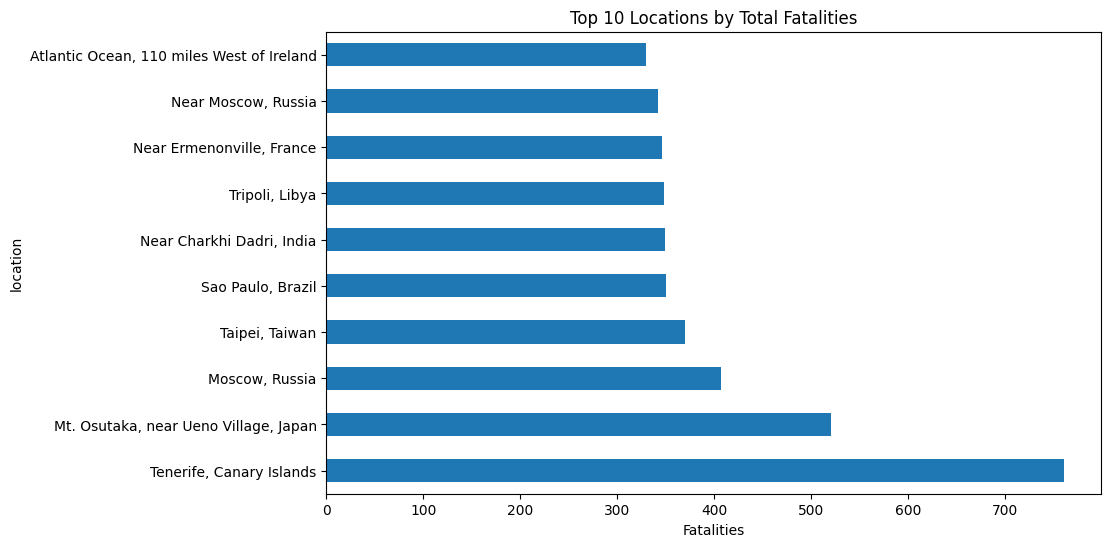

In [ ]:
# Top 10 locations with the most fatalities
top_locations = data.groupby('location')['all_fatalities'].sum().nlargest(10)

top_locations.plot(kind='barh', title="Top 10 Locations by Total Fatalities", figsize=(10,6))
plt.xlabel('Fatalities')
plt.show()

# Investigate the influence of time factors (e.g., time of day) on accident outcomes.

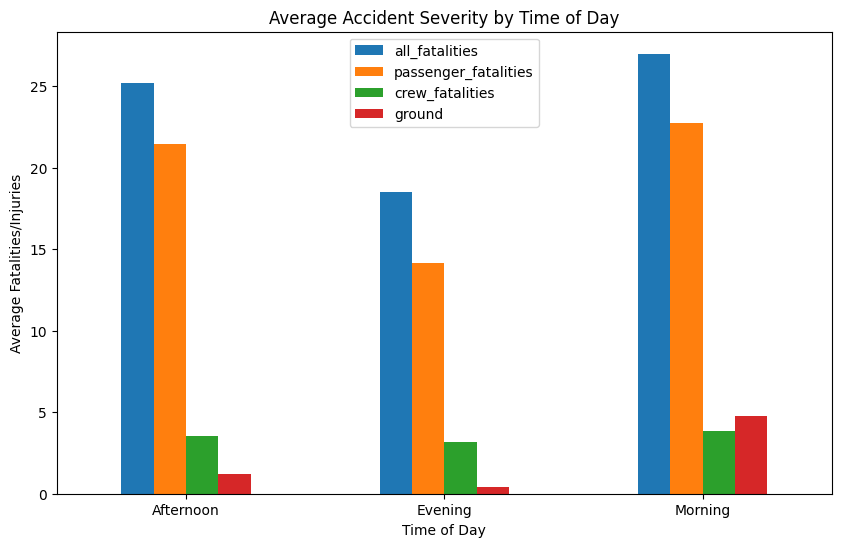

             all_fatalities  passenger_fatalities  crew_fatalities    ground
time_of_day                                                                 
Afternoon         25.171113             21.432383         3.530819  1.198712
Evening           18.515499             14.179487         3.147340  0.391887
Morning           26.997781             22.744822         3.824704  4.750000


In [ ]:
# Replace '?' with NaN in the 'time' column and fix invalid entries
data['time'] = data['time'].replace('?', np.nan)
data['time'] = pd.to_datetime(data['time'], format='%H:%M', errors='coerce')

# Extract hours from time for grouping
data['hour'] = data['time'].dt.hour

# Define time categories
def time_category(hour):
    if hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the time category function
data['time_of_day'] = data['hour'].apply(time_category)

# Check for columns related to accidents (e.g., all_fatalities, passenger_fatalities)
accident_columns = ['all_fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground']

# Calculate average accident severity for each time category
accident_stats = data.groupby('time_of_day')[accident_columns].mean()

# Plot the results
accident_stats.plot(kind='bar', figsize=(10,6))
plt.title('Average Accident Severity by Time of Day')
plt.ylabel('Average Fatalities/Injuries')
plt.xlabel('Time of Day')
plt.xticks(rotation=0)
plt.show()

# Display the accident stats
print(accident_stats)

# Assess the impact of major aviation innovations and regulations on the frequency and severity of accidents over time.

### Time series


In [ ]:
dataset= pd.read_csv('/content/drive/MyDrive/Plane Accident/Data/yearly_fatalities.csv')

In [ ]:
dataset

,year,all_fatalities
0,1908,1.0
1,1909,1.0
2,1912,5.0
3,1913,43.0
4,1915,36.0
...,...,...
109,2020,355.0
110,2021,185.0
111,2022,189.0
112,2023,102.0


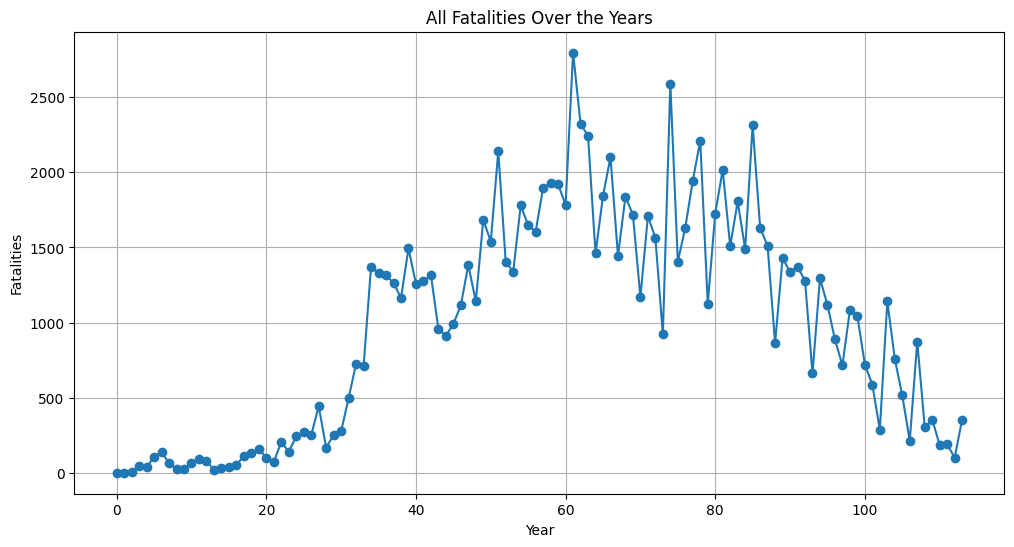

In [ ]:
# Convert the index to a column named 'year'
dataset.reset_index(inplace=True)



# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['all_fatalities'], marker='o', linestyle='-')
plt.title("All Fatalities Over the Years")
plt.xlabel("Year")
plt.ylabel("Fatalities")
plt.grid()
plt.show()

In [ ]:
print("Missing values:\n", dataset.isnull().sum())

Missing values:
 index             0
year              0
all_fatalities    0
dtype: int64


In [ ]:
# Perform ADF Test
result = adfuller(dataset['all_fatalities'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("The data is NOT stationary (p > 0.05), applying differencing.")
    dataset['diff_1'] = dataset['all_fatalities'].diff()
    dataset.dropna(inplace=True)  # Drop NA values after differencing

    # ADF test after differencing
    result = adfuller(dataset['diff_1'])
    print("ADF Statistic after differencing:", result[0])
    print("p-value after differencing:", result[1])

    if result[1] > 0.05:
        print("Further differencing might be needed.")
    else:
        print("Data is now stationary.")
else:
    print("The data is already stationary.")


ADF Statistic: -1.2328927388440205
p-value: 0.6592885024578734
The data is NOT stationary (p > 0.05), applying differencing.
ADF Statistic after differencing: -9.556208262423004
p-value after differencing: 2.495008532233583e-16
Data is now stationary.


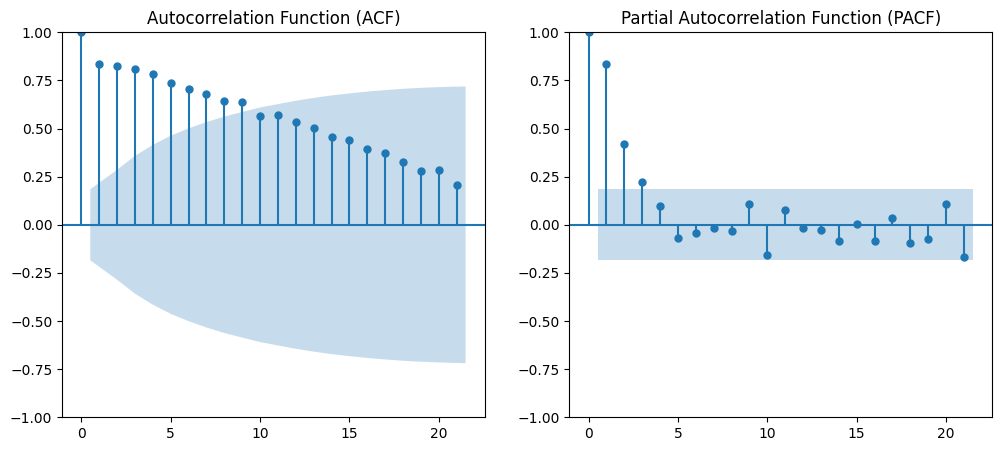

In [ ]:
# Plot ACF & PACF directly on the original 'all_fatalities' column
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(dataset['all_fatalities'].dropna(), ax=axes[0])  # Use original data
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(dataset['all_fatalities'].dropna(), ax=axes[1]) # Use original data
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

ACF Interpretation (Left Plot)
The ACF plot shows a slow decay, which confirms that the original time series is non-stationary (consistent with your ADF test results).
This slow decay suggests the presence of a unit root, indicating the need for differencing (which you already applied).
PACF Interpretation (Right Plot)
The first lag in PACF is strongly significant, followed by a sharp drop after lag 1.
This suggests that an AR(1) process might be appropriate.


In [ ]:
# Auto-ARIMA to find best (p, d, q)
auto_arima_model = auto_arima(dataset['all_fatalities'], seasonal=False, trace=True)
print(auto_arima_model.summary())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1622.710, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1664.236, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1632.306, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1621.886, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1662.244, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1621.686, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1622.320, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1621.430, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1620.519, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1621.036, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1623.043, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1618.540, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1619.921, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1619.444, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1619.051, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1619.698, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1621.048, Time=0.18 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.091 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -806.270
Date:                Tue, 04 Feb 2025   AIC                           1618.540
Time:                        17:31:35   BIC                           1626.696
Sample:                             0   HQIC                          1621.849
                                - 113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7504      0.086     -8.695      0.000      -0.920 

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size], dataset[train_size:]

# Check the split data
print(f'Training data size: {len(train)}')
print(f'Testing data size: {len(test)}')


Training data size: 90
Testing data size: 23


In [ ]:
test


,index,year,all_fatalities,diff_1
91,91,2002,1371.0,35.0
92,92,2003,1279.0,-92.0
93,93,2004,662.0,-617.0
94,94,2005,1294.0,632.0
95,95,2006,1118.0,-176.0
96,96,2007,888.0,-230.0
97,97,2008,716.0,-172.0
98,98,2009,1083.0,367.0
99,99,2010,1044.0,-39.0
100,100,2011,720.0,-324.0


In [ ]:
# Fit Auto-ARIMA model on training data
auto_arima_model_train = auto_arima(train['all_fatalities'], seasonal=False, trace=True)

# Print model summary
print(auto_arima_model_train.summary())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1294.591, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1326.534, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1299.705, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1291.644, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1324.655, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1291.987, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1291.448, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1293.390, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1293.310, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1293.763, Time=1.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1290.266, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1291.050, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1292.123, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1291.973, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1291.044, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1292.468, Time=1.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 7.777 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -642.133
Date:                Tue, 04 Feb 2025   AIC                           1290.266
Time:                        17:32:31   BIC                           1297.732
Sample:                             0   HQIC                          1293.276
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7315      0.097     -7.537      0.000      -0.922 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


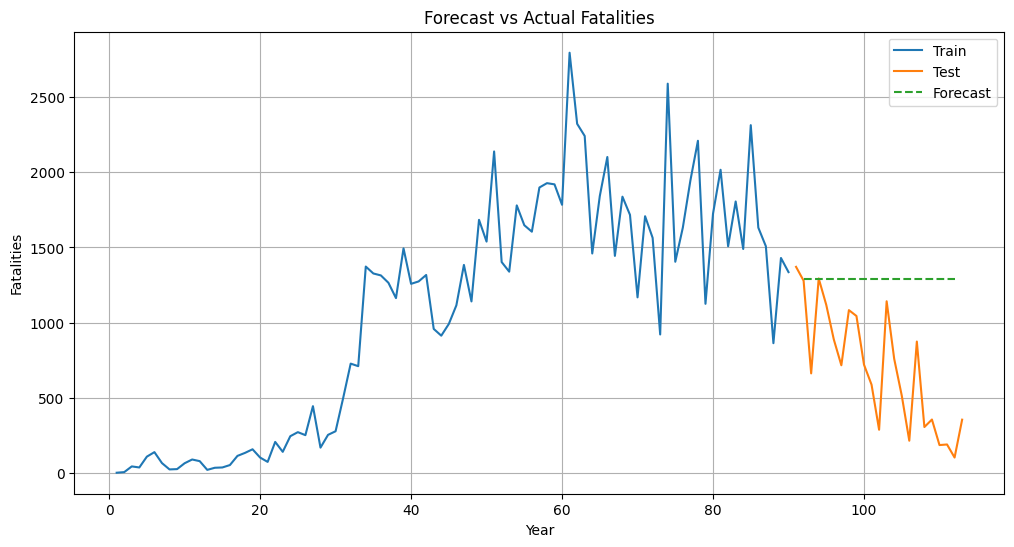

In [ ]:
# Forecast on test data
forecast = auto_arima_model_train.predict(n_periods=len(test))

# Create a DataFrame for the forecast and actual data comparison
# Align the index of the forecast with the index of the test data
forecast_df = pd.DataFrame({'Forecast': forecast}, index=test.index[1:])

# Add the 'Actual' column
forecast_df['Actual'] = test['all_fatalities'][1:]

# Reset the index to have a 'Year' column
forecast_df = forecast_df.reset_index().rename(columns={'index': 'Year'})

# Plot the forecast vs actual data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['all_fatalities'], label='Train')
plt.plot(test.index, test['all_fatalities'], label='Test')
plt.plot(forecast_df['Year'], forecast_df['Forecast'], label='Forecast', linestyle='--')  # Updated plotting
plt.title("Forecast vs Actual Fatalities")
plt.xlabel("Year")
plt.ylabel("Fatalities")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE, MAE
rmse = np.sqrt(mean_squared_error(test['all_fatalities'], forecast))
mae = mean_absolute_error(test['all_fatalities'], forecast)

# Calculate MAPE
mape = np.mean(np.abs((test['all_fatalities'] - forecast) / test['all_fatalities'])) * 100

# Print the error metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Root Mean Squared Error (RMSE): 712.3380662148433
Mean Absolute Error (MAE): 601.1380889433885
Mean Absolute Percentage Error (MAPE): 206.89099324923714%


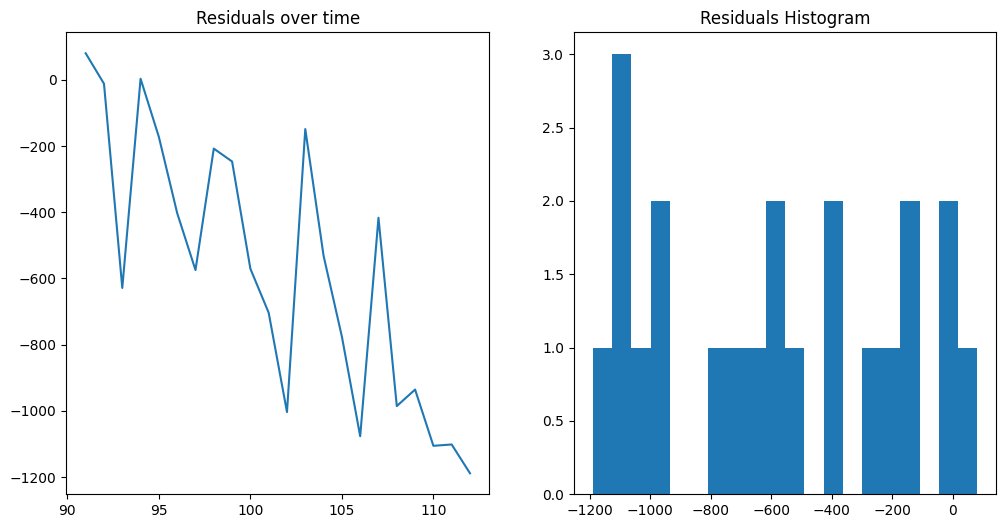

ADF Statistic for Residuals: 3.9272361889110785
p-value for Residuals: 1.0


In [ ]:
# Plot residuals of the model
residuals = test['all_fatalities'] - forecast

# Drop NaN values from residuals before applying the ADF test
residuals = residuals.dropna()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("Residuals over time")
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20)
plt.title("Residuals Histogram")
plt.show()

# Perform ADF test on residuals to check for stationarity
result_residuals = adfuller(residuals)
print("ADF Statistic for Residuals:", result_residuals[0])
print("p-value for Residuals:", result_residuals[1])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-93-1ad2242caa51>:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=test.index[-1], periods=6, freq='Y')[1:]


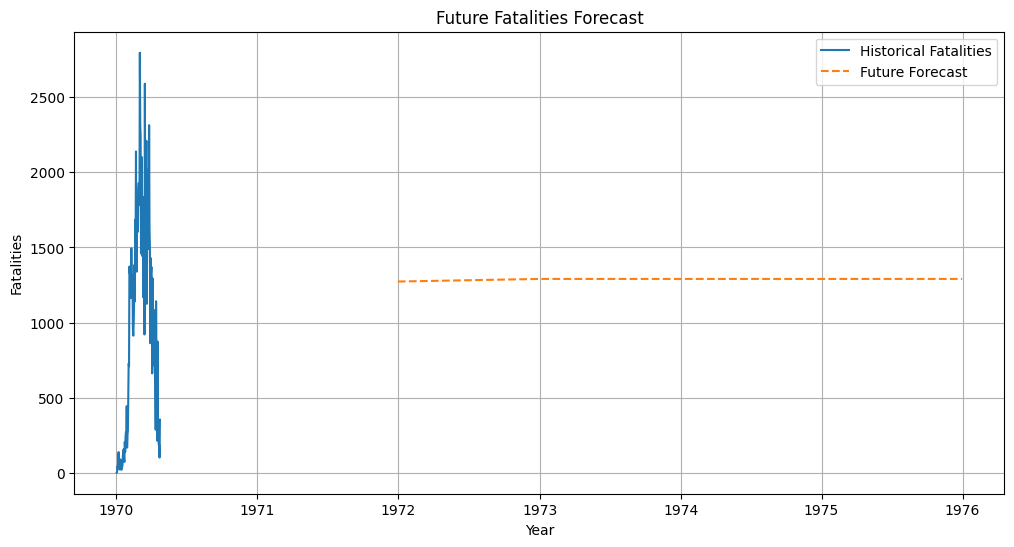

In [ ]:
# Forecast future values beyond the test set (e.g., for the next 5 years)
future_forecast = auto_arima_model_train.predict(n_periods=5)

# Plot the future forecast
future_years = pd.date_range(start=test.index[-1], periods=6, freq='Y')[1:]
plt.figure(figsize=(12, 6))
plt.plot(dataset['all_fatalities'], label='Historical Fatalities')
plt.plot(future_years, future_forecast, label='Future Forecast', linestyle='--')
plt.title("Future Fatalities Forecast")
plt.xlabel("Year")
plt.ylabel("Fatalities")
plt.legend()
plt.grid()
plt.show()
